In [1]:
#Imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
from scipy import stats
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
#Read data
df = pd.read_csv("../../Data/openpowerlifting-2021-03-31-ab223798.csv", index_col = 0)

C:\Users\Joe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (31,33,35,38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Data quality inspection and cleaning

First inspect data quality (missingness, erroneous entries, variable types, etc.). Note the lifter name is the index. Documentation of the metadata is available at https://openpowerlifting.gitlab.io/opl-csv/bulk-csv-docs.html

In [3]:
#df.head()
#df.shape
#df.columns
#df.dtypes.value_counts()
#df.describe()
#df.info()

2,419,464 observations, 40 rows (22 numeric, 18 categorical). Since our response variable/s will depend on the question being answered, we won't separate any response variables at this time. But we can separate categorical/numeric variables.

In [4]:
#Split data by numeric/categorical
Xnum = df[df.columns[df.dtypes != object]]
Xcat = df[df.columns[df.dtypes == object]]

### Missing data

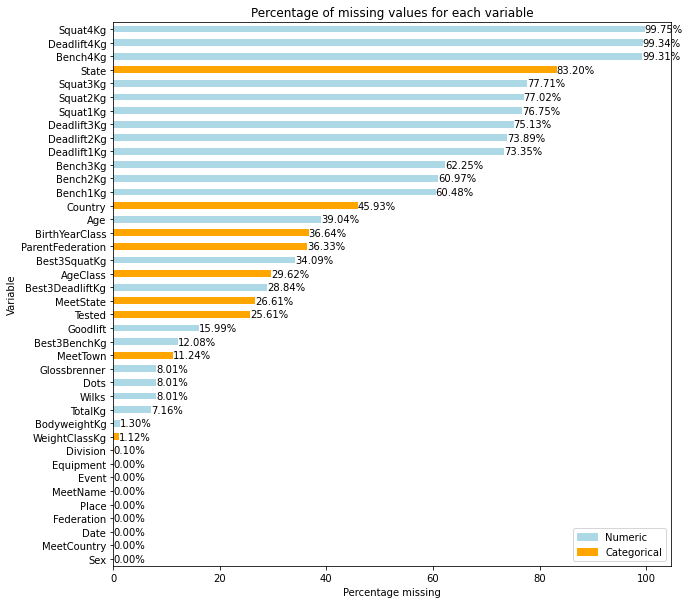

In [5]:
#Calculate percentage of nulls for each var and plot them
null_prop = (df.isnull().sum()/len(Xnum)*100).sort_values()
type_color = np.where(null_prop.index.isin(Xcat.columns), 'orange', 'lightblue')
ax = null_prop.plot.barh(color = type_color, figsize=(10, 10))
plt.title("Percentage of missing values for each variable")
plt.xlabel("Percentage missing")
plt.ylabel("Variable")

#Add custom legend (default legend doesn't work here)
num_patch = mpatches.Patch(color='lightblue', label="Numeric")
cat_patch = mpatches.Patch(color='orange', label="Categorical")
plt.legend(handles=[num_patch, cat_patch], loc = 4)

#Add annotations
for y, x in enumerate(null_prop):
    plt.annotate("{:.2f}%".format(x), xy=(x, y), va='center')

Of note:
- State and country are the most missing categorical variables. These pertain to the lifter's state/country of origin, which isn't likely to be documented at a meet. The meet country, however, has no missingness.
- 4th attempt lifts are almost all missing, because 4th attempts are rare.
- Individual lift attempt weights are mostly missing, which is unfortunate since they'll be useful for answering strategy questions. However, the large amount of observations means there's still plenty of data to work with here.

Often missingness might indicate non-relevancy rather than lack of information (e.g. no recorded total if disqualified). We'll check for this now.

In [6]:
print("Prop. without age info:", df[df['Age'].isnull() & df['AgeClass'].isnull() & 
                                 df['BirthYearClass'].isnull()].shape[0]/len(df))

print("Prop. without total info:", df[df.TotalKg.isnull() & 
                                    df.Place.str.isnumeric()].shape[0]/len(df))

#Separate attempt columns
squat_attempts = df[["Squat1Kg", "Squat2Kg", "Squat3Kg"]]
bench_attempts = df[["Bench1Kg", "Bench2Kg", "Bench3Kg"]]
dead_attempts = df[["Deadlift1Kg", "Deadlift2Kg", "Deadlift3Kg"]]

print("\nProportion without best lift but some successful attempt:")
print("Squat:", df[df.Best3SquatKg.isnull() & (squat_attempts > 0).any(axis = 1)].shape[0]/len(df))
print("Bench:", df[df.Best3BenchKg.isnull() & (bench_attempts > 0).any(axis = 1)].shape[0]/len(df))
print("Deadlift:", df[df.Best3DeadliftKg.isnull() & (dead_attempts > 0).any(axis = 1)].shape[0]/len(df))

print("\nProportion with best lift only:")
print("Squat:", df[df.Best3SquatKg.notnull() & squat_attempts.isnull().all(axis = 1)].shape[0]/len(df))
print("Bench:", df[df.Best3BenchKg.notnull() & bench_attempts.isnull().all(axis = 1)].shape[0]/len(df))
print("Deadlift:", df[df.Best3DeadliftKg.notnull() & dead_attempts.isnull().all(axis = 1)].shape[0]/len(df))

print("\nProportion with some but not null attempts:")
print("Squat:", df[squat_attempts.isnull().any(axis = 1) & ~squat_attempts.isnull().all(axis = 1)].shape[0]/len(df))
print("Bench:", df[bench_attempts.isnull().any(axis = 1) & ~bench_attempts.isnull().all(axis = 1)].shape[0]/len(df))
print("Deadlift:", df[dead_attempts.isnull().any(axis = 1) & ~dead_attempts.isnull().all(axis = 1)].shape[0]/len(df))

Prop. without age info: 0.2809448704341127
Prop. without total info: 0.0

Proportion without best lift but some successful attempt:
Squat: 0.0
Bench: 0.0
Deadlift: 0.0

Proportion with best lift only:
Squat: 0.4326929435610532
Bench: 0.4977805001438335
Deadlift: 0.44816331220468664

Proportion with some but not null attempts:
Squat: 0.011114858497584588
Bench: 0.019749002258351436
Deadlift: 0.01922367929425691


Of note:
- ~28% of lifters don't have an age, age class, or birth year class recorded
- All observation either have a total or a reason for no total (e.g. disqualified, no-show)
- All observation with nulls for best individual lifts are due to 3x failed lifts, or the lift not performed in the competition
- 40-50% of observations (per lift) only record best attempts - not individual attempts
- 1-2% of observations (per lift) have partially recorded individual attempts
    - This may be due to mid-competition injury/resign, showing up late, etc.

### Duplicates

In [7]:
dups = df[df.duplicated(keep = False)]
true_dups = dups[dups.index.duplicated(keep = False)]

There are 17,538 duplicate rows, with 6960 duplicate indices. Some of these are duplicated multiple times. We want to delete all duplicates, but keep one of each unique row.

In [8]:
df['TempIndex'] = df.index
df.drop_duplicates(inplace = True)
df.drop(columns = ['TempIndex'], inplace = True)

### Erroneous data

In [9]:
df.describe()

,Age,BodyweightKg,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Bench4Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Deadlift4Kg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift
count,1.473424e+06,2.385361e+06,562294.000000,555649.000000,539114.000000,6056.000000,1.593471e+06,955530.000000,943636.000000,912607.000000,16758.000000,2.124956e+06,644377.000000,631356.000000,601290.000000,15904.000000,1.719833e+06,2.243938e+06,2.223333e+06,2.223333e+06,2.223333e+06,2.031000e+06
mean,3.077139e+01,8.389784e+01,112.118987,92.565738,32.732836,72.993265,1.740532e+02,83.254969,55.023834,-17.949617,23.266745,1.187271e+02,159.230087,129.813141,17.103261,77.942691,1.883343e+02,3.743534e+02,2.726272e+02,2.716550e+02,2.561428e+02,6.355163e+01
std,1.313741e+01,2.272296e+01,143.617884,168.725722,195.620289,187.675043,6.981291e+01,104.228938,128.973869,142.959061,164.175561,5.479179e+01,109.504563,159.600717,212.029267,188.565439,6.255168e+01,2.062958e+02,1.297897e+02,1.292976e+02,1.229859e+02,1.625155e+01
min,0.000000e+00,1.510000e+01,-555.000000,-580.000000,-600.500000,-550.000000,-5.080200e+02,-502.500000,-575.000000,-575.000000,-515.000000,-5.225000e+02,-461.000000,-470.000000,-587.500000,-461.000000,-4.100000e+02,1.000000e+00,6.800000e-01,6.700000e-01,6.400000e-01,5.000000e-01
25%,2.050000e+01,6.695000e+01,87.500000,70.000000,-160.000000,-97.640000,1.224700e+02,55.000000,-52.500000,-140.000000,-125.612500,7.500000e+01,125.000000,115.000000,-205.000000,-100.000000,1.400000e+02,2.000000e+02,1.410400e+02,1.404800e+02,1.330700e+02,5.179000e+01
50%,2.750000e+01,8.187000e+01,145.000000,142.500000,110.000000,132.500000,1.700000e+02,105.000000,95.000000,-60.000000,75.000000,1.150000e+02,180.000000,175.000000,117.500000,142.500000,1.875000e+02,3.480000e+02,2.931500e+02,2.923100e+02,2.728600e+02,6.322000e+01
75%,3.850000e+01,9.880000e+01,200.000000,202.500000,190.000000,200.000000,2.183850e+02,145.000000,145.000000,120.000000,155.000000,1.525000e+02,225.000000,230.000000,205.000000,206.380000,2.336000e+02,5.300000e+02,3.705400e+02,3.689900e+02,3.495200e+02,7.486000e+01
max,9.800000e+01,2.602000e+02,555.000000,577.500000,560.000000,592.390000,5.810500e+02,490.000000,487.500000,500.000000,487.610000,5.034900e+02,450.000000,460.400000,457.500000,440.500000,4.604000e+02,1.407500e+03,7.952200e+02,7.933300e+02,7.569000e+02,1.464900e+02


Given the large sample size, there will be many outliers. But for now, we're looking for erroneous entries. The only obvious issues here are that some ages are very young (min. is 0) and some bodyweight are possibly in lbs.

I'll remove observations with age < 5 as this is the minimum age of the lowest age division. 261 rows.
I'll also remove Mx Sex rows, as there's not enough to make comparisons with M/F.

In [10]:
df.drop(df[df['Age'] < 5].index, inplace=True)
df.drop(df[df['Sex'] == 'Mx'].index, inplace=True)

In [11]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.to_csv("../../Data/OP_Cleaned.csv")